In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import wordcloud
import Uncertainty as unc
import UncertaintyM as uncM
import matplotlib.pyplot as plt
import data_provider as dp
from classes.wordclouds import Wordcloud
from wordcloud import STOPWORDS

In [2]:
episodes = 100
unc_embeddings = 10
test_split = 0.3
log = True
unc_plot = False
seed = 1

In [3]:
# load the data
features_all, targets_all, text_all = dp.load_data("./Data/")
features_list, targets_list, text_list = dp.partition_data(features_all, targets_all, text_all, episodes)

episode  0
------------------------------------
model test score =  0.6249201550057488


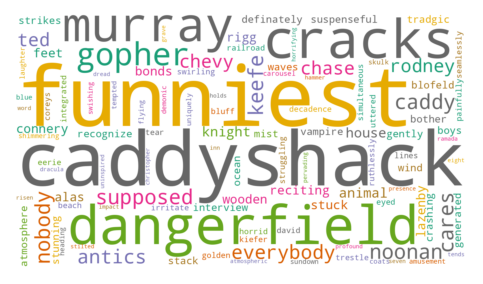

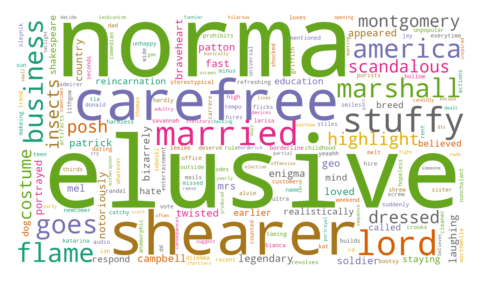

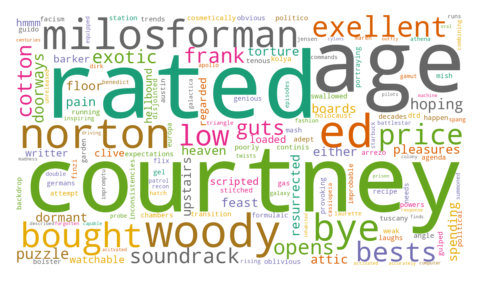

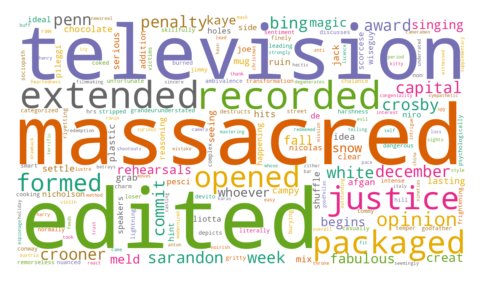

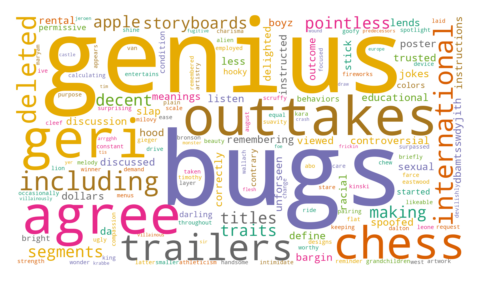

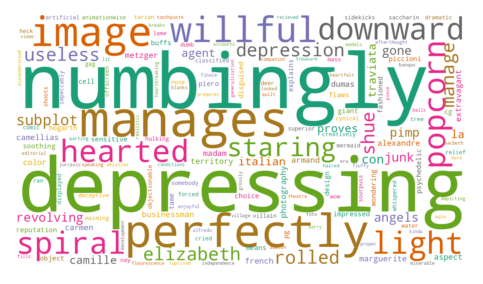

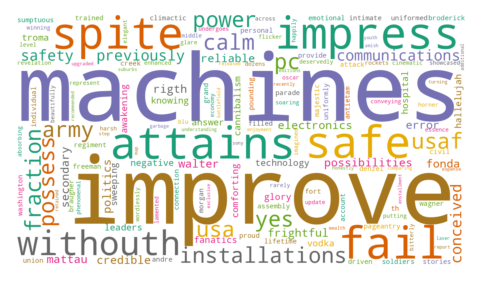

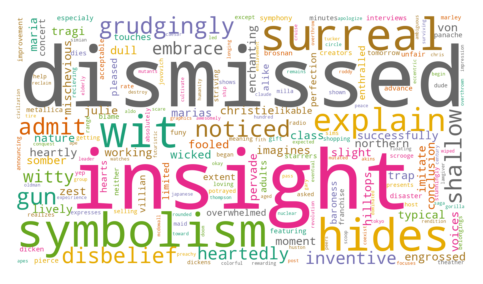

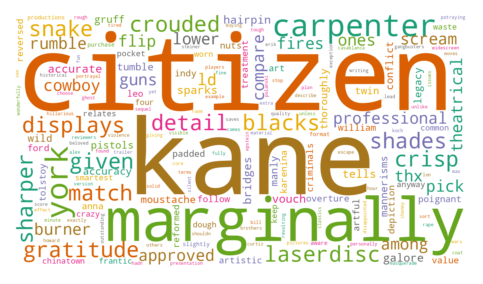

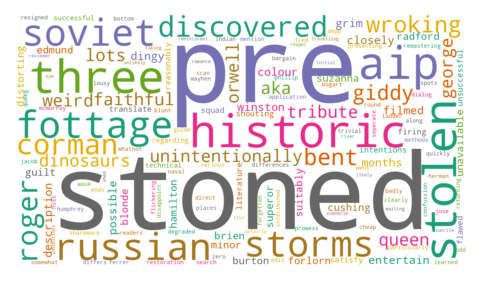

In [6]:
for episode, (features, targets, texts) in enumerate(zip(features_list, targets_list, text_list)):

    print("episode ", episode)
    print("------------------------------------")

    # split and shuffel the data
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_split, shuffle=False, random_state=seed)
    _,       text_test, _   , _      = train_test_split(texts,    targets, test_size=test_split, shuffle=False, random_state=seed)

    # train the model
    model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=1)
    model.fit(X_train, y_train[:,0]) # remove keys when fiting the model

    predictions = model.predict(X_test)
    if log:
        print("model test score = ", model.score(X_test, y_test[:,0]))

    # Aleatoric uncertianty for X_test
    total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = unc.model_uncertainty(model, X_test, X_train, y_train[:,0])

    # AR plot
    if unc_plot:
        avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test[:,0].reshape((1,-1)), total_uncertainty.reshape((1,-1)))
        plt.plot(steps, avg_acc*100)
        plt.savefig(f"./Results/AR_plot.png",bbox_inches='tight')

    # sort based on uncertianty
    sorted_index = np.argsort(-total_uncertainty, kind='stable')
    text_test = np.array(text_test)
    text_test = text_test[sorted_index]
    # epistemic_uncertainty = epistemic_uncertainty[sorted_index]

    # Get uncertainty per class
    u = np.unique(y_test[:,0]) # find the unique classes

    tokens_high_class_list = []
    tokens_low_class_list  = []
    tokens_all = None
    wordcloud = Wordcloud()

    for class_value in u: # this loop runs for every class in the dataset
        index = np.where(y_test[:,0]==class_value)[0]
        unc_sorted_class_text = text_test[index]

        wordcloud_text_array = unc_sorted_class_text[:unc_embeddings]
        tokens_high = wordcloud.get_tokens(list(wordcloud_text_array))
        tokens_high_class_list.append(tokens_high)

        wordcloud_text_array = unc_sorted_class_text[-unc_embeddings:]
        tokens_low = wordcloud.get_tokens(list(wordcloud_text_array))
        tokens_low_class_list.append(tokens_low)

        class_tokens = tokens_high + tokens_low

        if tokens_all == None:
            tokens_all = class_tokens
        else:
            tokens_all += class_tokens

    for i in range(len(u)):
        tokens = tokens_high_class_list[i]
        for item, count in tokens.items():
            tokens[item] /= tokens_all[item]
        tokens_high_class_list[i] = tokens

        tokens = tokens_low_class_list[i]
        for item, count in tokens.items():
            tokens[item] /= tokens_all[item]
        tokens_low_class_list[i] = tokens

    # Create wordcloud
    for i, class_value in enumerate(u):
        cloud = wordcloud.get_wordcloud(tokens_high_class_list[i])
        wordcloud.plot(cloud, f"High_class_{class_value}_e{episode}")

        cloud = wordcloud.get_wordcloud(tokens_low_class_list[i])
        wordcloud.plot(cloud, f"Low_class_{class_value}_e{episode}")

    break
    
